(examples:prism_quickstart)=
# PRISM quickstart

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ase.build import bulk
from ase.cluster import Decahedron
from dask.distributed import Client

import abtem

<AxesSubplot:xlabel='x [Å]', ylabel='z [Å]'>

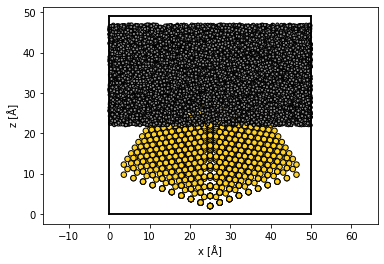

In [2]:
carbon = bulk('C', cubic=True)

carbon *= (14, 14, 7) 

carbon.positions[:] += np.random.randn(len(carbon), 3) * .5 # displace atoms with a standard deviation of .5 Å

carbon.wrap()


cluster = Decahedron('Au', 
                     10, # Number of atoms on the facets perpendicular to the five fold axis.
                     2, # Number of atoms on the facets parallel to the five fold axis.
                     0 # Depth of re-entrence at the pentagon corners.
                    )


cluster.rotate('x', -30)

center_height = -20

translated_cluster = cluster.copy()

translated_cluster.translate(np.diag(carbon.cell) / 2 + (0, 0, center_height))

cluster_on_carbon = carbon + translated_cluster

cluster_on_carbon.center(axis=2, vacuum=2)

abtem.show_atoms(cluster_on_carbon, plane='xz')

In [3]:
client = Client()

In [16]:
frozen_phonons = abtem.FrozenPhonons(cluster_on_carbon, 1, {'C':.0, 'Au':0.})

potential = abtem.Potential(frozen_phonons, 
                            gpts = 1024,
                            projection = 'infinite', 
                            slice_thickness = 2,
                            )

In [17]:
s_matrix = abtem.SMatrix(potential=potential, energy=200e3, planewave_cutoff=20, interpolation=4)

s_matrix.build().array

,Array,Chunk
Bytes,1.06 GiB,53.54 MiB
Shape,"(1, 305, 684, 684)","(1, 15, 684, 684)"
Count,45 Tasks,21 Chunks
Type,complex64,numpy.ndarray


In [18]:
s_matrix.cutoff_angles

(171.109544782093, 171.109544782093)

In [19]:
detectors = abtem.FlexibleAnnularDetector()

measurement = s_matrix.scan(detectors=detectors)

In [20]:
measurement.array

dask.array<mean_agg-aggregate, shape=(178, 178, 114, 1), dtype=float32, chunksize=(45, 45, 114, 1), chunktype=numpy.ndarray>

In [21]:
measurement.compute()

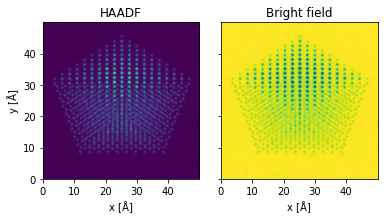

In [32]:
integrated_measurement = abtem.stack((measurement.integrate_radial(50, 150),
                                      measurement.integrate_radial(0, 20)
                                     ),
                                    axis_metadata=('HAADF', 'Bright field')
                                    )

integrated_measurement.show(explode=True);

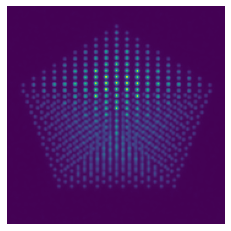

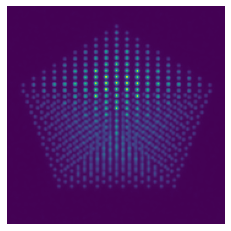

In [38]:
from myst_nb import glue

fig, ax = integrated_measurement.show(figsize=(4,4))
ax.axis('off')

glue("prism_quickstart", ax.get_figure(), display=False)